# Sequential Forward Feature Selection

In this tutorial we go through the **Sequential Forward Feature Selection**, given a set of initial features, used to selected few "informative" from a pool of features. More details on the SFFS method can be found here : [MLX Tend Feature Selection](https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector)

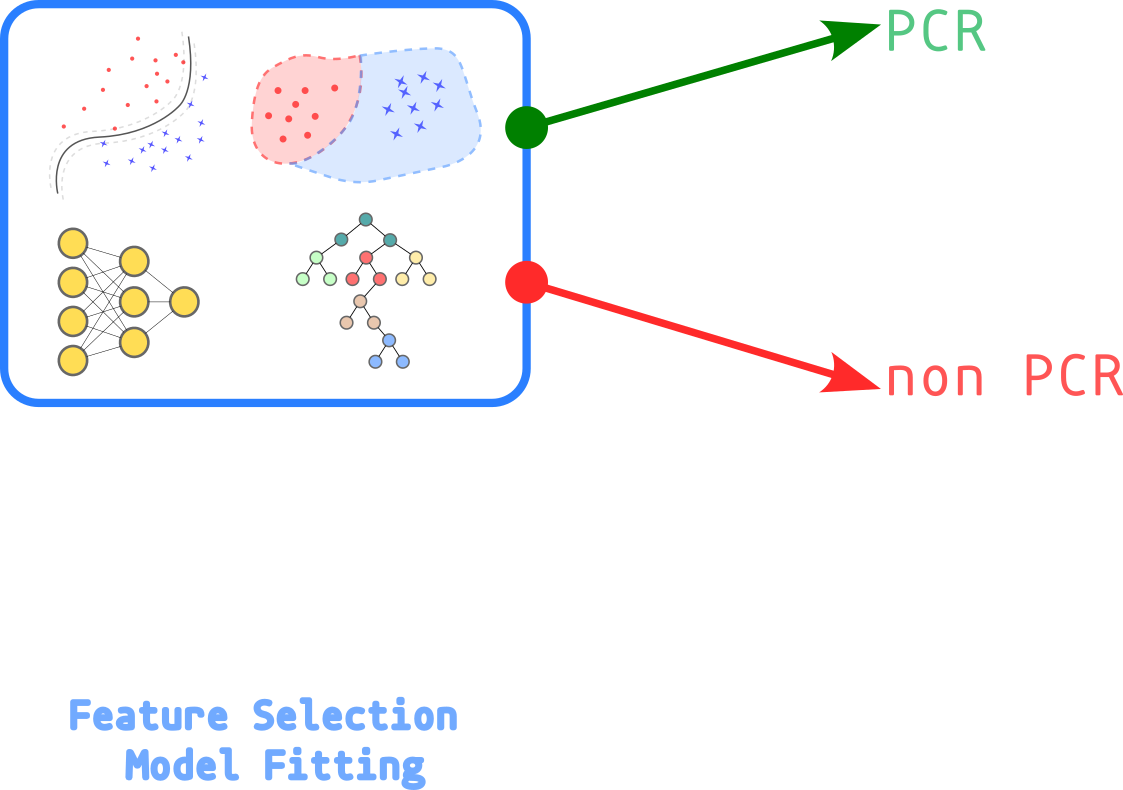

## Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from Hive_ML.utilities.feature_utils import data_shuffling
import json 
from importlib.resources import as_file, files
import Hive_ML.configs
import os

In [2]:
from Hive_ML.training.models import adab_tree, random_forest, knn, decicion_tree, lda, qda, naive, svm_kernel, logistic_regression, ridge, mlp

MODELS = {
    "rf": random_forest,
    "adab": adab_tree,
    "lda": lda,
    "qda": qda,
    "logistic_regression": logistic_regression,
    "knn": knn,
    "naive": naive,
    "decision_tree": decicion_tree,
    "svm": svm_kernel,
    "ridge": ridge,
    "mlp": mlp
}

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

## Load Configuration


In [4]:
config_file = "Radiodynamics_config.json"

try:
    with open(config_file) as json_file:
        config_dict = json.load(json_file)
except FileNotFoundError:
    with as_file(files(Hive_ML.configs).joinpath(config_file)) as json_path:
        with open(json_path) as json_file:
            config_dict = json.load(json_file)

## Features Loading and Aggregation

Radiomics Features are aggregagated across the 3D Sequences:

$F\mu_{p,i}=\frac{1}{N} \sum_{n=0}^N F_{n, p, i}$

$F\sigma_{p,i}= \sqrt{\frac{\sum_{n=0}^N (F_{n, p, i} - F\mu_{p,i})^2}{N}}$

$F\Delta_{p,i}=\frac{1}{N} \sum_{n=0}^N |F_{n, p, i}- F\mu_{p,i}|$

with $ p = patient_p, i = feature_i$

In [5]:
def get_feature_set_details(feature_set):

    n_sequences = feature_set[["Subject_ID", "Sequence_Number"]].groupby("Subject_ID").count()
    n_sequences = max(n_sequences["Sequence_Number"])
    subjects_and_labels = feature_set[["Subject_ID", "Subject_Label"]].drop_duplicates()

    subject_ids = subjects_and_labels["Subject_ID"].values
    subject_labels = subjects_and_labels["Subject_Label"].values

    feature_list = []
    for sequence in range(n_sequences):
        sequence_feature_list = []
        for subject in subject_ids:
            feature_set_subject = feature_set[
                (feature_set["Subject_ID"] == subject) & (feature_set["Sequence_Number"] == sequence)]
            feature_set_subject = feature_set_subject.copy(deep=True)
            feature_set_subject.drop("Subject_ID", inplace=True, axis=1)
            feature_set_subject.drop("Subject_Label", inplace=True, axis=1)
            feature_set_subject.drop("Sequence_Number", inplace=True, axis=1)
            if feature_set_subject.values.shape[0] > 0:
                sequence_feature_list.append(feature_set_subject.values)
            else:
                nan_array = np.empty((1, feature_set_subject.values.shape[1]))
                nan_array[:] = np.nan
                sequence_feature_list.append(nan_array)
        feature_list.append(sequence_feature_list)

    feature_set_names = feature_set.copy(deep=True)
    feature_set_names.drop("Subject_ID", inplace=True, axis=1)
    feature_set_names.drop("Subject_Label", inplace=True, axis=1)
    feature_set_names.drop("Sequence_Number", inplace=True, axis=1)
    feature_names = feature_set_names.columns
    return feature_list, subject_ids, subject_labels, feature_names


In [6]:
def get_4D_feature_stats(feature_list):

    feature_arrays = np.array(feature_list).squeeze(axis=-2)

    mean_features = np.nanmean(feature_arrays, axis=0)
    sum_features = np.nansum(feature_arrays, axis=0)
    std_features = np.nanstd(feature_arrays, axis=0)

    delta_features = np.absolute(np.subtract(feature_arrays, mean_features))
    mean_delta_features = np.nanmean(delta_features, axis=0)

    return mean_features, sum_features, std_features, mean_delta_features

In [8]:
data_folder = "Data/DCE_MRI_dataset"
feature_set_filename = str(Path(data_folder).joinpath("Perfusion_Radiomics.xlsx"))
feature_set = pd.read_excel(feature_set_filename, index_col=0)

feature_set = feature_set.sort_values(by=['Subject_Label','Subject_ID','Sequence_Number'])

feature_list, subject_ids, subject_labels, feature_names = get_feature_set_details(feature_set)
mean_features, sum_features, std_features, mean_delta_features = get_4D_feature_stats(feature_list)

## 3D Feature Array Flattening into 2D Array

$ F_{n,p,i} $ to $ F_{p,i*n} $

In [9]:
def flatten_4D_features(feature_list, feature_names):
    feature_arrays = np.array(feature_list).squeeze(axis=-2)
    flat_feature_array = np.zeros((feature_arrays.shape[1], 1))

    if feature_arrays.shape[0] > 1:
        T = feature_arrays.shape[0]
        n_features = feature_arrays.shape[2]
        for n in range(n_features):
            for t in range(T):
                flat_feature_array = np.hstack(
                    [flat_feature_array, feature_arrays[t, :, n].reshape(feature_arrays.shape[1], 1)])

        flatten_feature_names = []
        for feature_name in feature_names:
            for t in range(T):
                flatten_feature_names.append("{}_{}".format(t, feature_name))
        return flat_feature_array[:, 1:], flatten_feature_names

    else:
        return feature_list, feature_names

In [10]:
feature_list_flatten, feature_names_flatten = flatten_4D_features(feature_list, feature_names)

label_set = np.array(subject_labels)

In [11]:
print("# Features: {}".format(feature_list_flatten.shape[1:]))
print("#Labels: {}".format(label_set.shape))

# Features: (352,)
#Labels: (80,)


## Feature Filtering

Features where > 50% of values are identical are removed.

In [12]:
#features = mean_features
features = feature_list_flatten
feature_names = feature_names_flatten

n_features = features.shape[1]
n_subjects = features.shape[0]

filtered_feature_set = []
filtered_feature_names = []
features = np.nan_to_num(features)
for feature in range(n_features):
    exclude = False
    for feature_val in np.unique(features[:, feature]):
        if (np.count_nonzero(features[:, feature] == feature_val) / n_subjects) > 0.5:
            exclude = True
            print("Excluding:", feature_names[feature])
            break

    if not exclude:
        filtered_feature_set.append(list(features[:, feature]))
        filtered_feature_names.append(feature_names[feature])


Excluding: 0_original_firstorder_10Percentile
Excluding: 0_original_firstorder_90Percentile
Excluding: 0_original_firstorder_Entropy
Excluding: 3_original_firstorder_Entropy
Excluding: 0_original_firstorder_Maximum
Excluding: 0_original_firstorder_Minimum
Excluding: 0_original_firstorder_Range
Excluding: 0_original_firstorder_Uniformity
Excluding: 3_original_firstorder_Uniformity
Excluding: 0_original_glcm_Autocorrelation
Excluding: 3_original_glcm_Autocorrelation
Excluding: 0_original_glcm_ClusterProminence
Excluding: 3_original_glcm_ClusterProminence
Excluding: 0_original_glcm_ClusterShade
Excluding: 3_original_glcm_ClusterShade
Excluding: 0_original_glcm_ClusterTendency
Excluding: 3_original_glcm_ClusterTendency
Excluding: 0_original_glcm_Contrast
Excluding: 3_original_glcm_Contrast
Excluding: 0_original_glcm_Correlation
Excluding: 3_original_glcm_Correlation
Excluding: 0_original_glcm_DifferenceAverage
Excluding: 3_original_glcm_DifferenceAverage
Excluding: 0_original_glcm_Differen

In [13]:
feature_set = np.vstack(filtered_feature_set).T
feature_names = filtered_feature_names

print("# Features: {}".format(feature_set.shape[1]))
print("#Labels: {}".format(label_set.shape))

# Features: 266
#Labels: (80,)


In [14]:
train_feature_set, train_label_set,test_feature_set, test_label_set = data_shuffling(feature_set, label_set, config_dict["random_seed"])

print(train_feature_set.shape)
print(test_feature_set.shape)

(64, 266)
(16, 266)


### 3D Features

This section has to be executed ONLY for 3D feature set

In [23]:
feature_set_3D = np.array(feature_list).squeeze(-2)
print(feature_set_3D.shape)

train_feature_set, train_label_set,test_feature_set, test_label_set = data_shuffling(np.swapaxes(feature_set_3D, 0, 1), label_set, config_dict["random_seed"])


print(train_feature_set.shape)
print(test_feature_set.shape)

(4, 80, 88)
(65, 4, 88)
(15, 4, 88)


## Experiment Folder Creation

*experiment_name* and the type of *aggregation* are set here.

In [17]:
os.environ["ROOT_FOLDER"] = "Experiments"

In [18]:
experiment_name = "Perfusion_Radiomics"

aggregation = "Flat"

experiment_dir = Path(os.environ["ROOT_FOLDER"]).joinpath(
        experiment_name,config_dict["feature_selection"],aggregation,"FS")
experiment_dir.mkdir(parents=True, exist_ok=True)

## Sequential Forward Feature Selection

The maximum number of selected features is set in *config_dict.n_features*.


In [19]:
def prepare_features(feature_set, label_set, train_index, aggregation, val_index = None,test_feature_set=None,test_label_set=None):
    x_val = None
    y_val = None

    if test_feature_set is not None:
        x_train = feature_set
        x_val = test_feature_set
    else:
        x_train = feature_set[train_index, :]
        if val_index is not None:
            x_val = feature_set[val_index, :]

    if test_label_set is not None:
        y_train = label_set
        y_val = test_label_set
    else:
        y_train = label_set[train_index]
        if val_index is not None:
            y_val = label_set[val_index]

    if len(x_train.shape) > 2:
        for t in range(x_train.shape[1]):
            min_max_norm = preprocessing.MinMaxScaler(feature_range=(0, 1))
            x_train[:, t, :] = min_max_norm.fit_transform(x_train[:, t, :])
            if x_val is not None:
                x_val[:, t, :] = min_max_norm.transform(x_val[:, t, :])

    if aggregation == "Mean_Norm":
        x_train = np.nanmean(x_train, axis=1)
        if x_val is not None:
            x_val = np.nanmean(x_val, axis=1)
    elif aggregation == "SD_Norm":
        x_train = np.nanstd(x_train, axis=1)
        if x_val is not None:
            x_val = np.nanstd(x_val, axis=1)

    return x_train, y_train, x_val, y_val

In [20]:
def feature_normalization(x_train, x_val=None, x_test=None):
    min_max_norm = preprocessing.MinMaxScaler(feature_range=(0, 1))
    x_train = min_max_norm.fit_transform(x_train)
    if x_val is not None:
        x_val = min_max_norm.transform(x_val)

    if x_test is not None:
        x_test = min_max_norm.transform(x_test)

    return x_train, x_val, x_test

In [21]:
selected_features = {}

models = config_dict["models"]

classifier = "qda"

selected_features[classifier] = {}
kf = StratifiedKFold(n_splits=config_dict["n_folds"], random_state=config_dict["random_seed"], shuffle=True)
for fold, (train_index, _) in enumerate(kf.split(train_feature_set, train_label_set)):
    
    x_train, y_train,_,_ = prepare_features(train_feature_set, train_label_set, train_index, aggregation)

    n_features = config_dict["n_features"]
    if n_features > x_train.shape[1]:
        n_features = x_train.shape[1]

    x_train, _, _ = feature_normalization(x_train)

    clf = MODELS[classifier](**models[classifier],random_state=config_dict["random_seed"])
    sffs_model = SFS(clf,
                     k_features=n_features,
                     forward=True,
                     floating=True,
                     scoring='roc_auc',
                     verbose=0,
                     n_jobs=-1,
                     cv=5)
    df_features_x = []
    for x_train_row in x_train:
        df_row = {}
        for idx, feature_name in enumerate(feature_names):
            df_row[feature_name] = x_train_row[idx]
        df_features_x.append(df_row)

    df_features_x = pd.DataFrame.from_records(df_features_x)
    sffs = sffs_model.fit(df_features_x, y_train)

    sffs_features = sffs.subsets_
    for key in sffs_features:
        sffs_features[key]['cv_scores'] = sffs_features[key]['cv_scores'].tolist()

    selected_features[classifier][fold] = sffs_features
    with open(str(Path(experiment_dir).joinpath(f"FS_summary_{classifier}_fold_{fold}.json")), "w") as f:
        json.dump(sffs_features, f)